#Creating a simple neural network - MLP (Multi-Layer Perceptron)

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
import math
from sklearn.utils.class_weight import compute_class_weight
from keras import regularizers
from imblearn.over_sampling import SMOTE


In [14]:
y = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/experimental_dataset_labels.csv', index_col=False)
X = data = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/scaled_experimental_dataset.csv', index_col=False)

# Split the data into training, validation and test sets

In [15]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# Split into training, validation and test data
# Stratify to get even distribution of classes in the training and test data
# This is useful because we have an uneven class proprtion (far fewer fraudulent transactions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify=y)

# Create validation set as 15% of orginal dataset (not 10% of X_train which would be 10% of 80%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test)

In [16]:
# check fraudulent transactions are distribited in the same
print(y_train.value_counts()[1] / y.value_counts()[1])
print(y_test.value_counts()[1]/ y.value_counts()[1])
print(y_val.value_counts()[1]/ y.value_counts()[1])

0.7962962962962963
0.10185185185185185
0.10185185185185185


# SMOTE

In [66]:
smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [67]:
# Count class occurrences in the resampled data
class_counts = dict(zip(*np.unique(y_train_resampled, return_counts=True)))
class_counts

{0: 8974, 1: 8974}

## MLP

tunable-hyperparameters:
* Number of hidden layers
* Number of Neurons in each layer
* weight regularization (l1, l2 - weigth decay)
* class_weights
* drop out layers
* optimisers
* optimiser learning rate

# Experimental results
input - 16 neurons with l2
drop out 0.5
hidden 16 neurons with l2
dropout 0.5
output roc = 0.84

input 100 +l2 drop out 0.5 hiddel 32 + l2, drop 0.5, hidden 36 + l2 roc = 0.86

In [90]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, kernel_regularizer=regularizers.l1(0.001), input_shape=(11, ), activation="relu"))

model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(keras.layers.Dense(8, kernel_regularizer=regularizers.l1(0.001), activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

In [91]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 200)               2400      
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_30 (Dense)            (None, 100)               20100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 32)                3232      
                                                                 
 dense_32 (Dense)            (None, 8)                 264       
                                                                 
 dense_33 (Dense)            (None, 1)                

# Adding class weights
This will penalise the positive class (malicious) *less* than it normally would

In [59]:
# ratio of positive:negative class
class_counts = dict(zip(*np.unique(y_train, return_counts=True)))
div = math.gcd(class_counts[0], class_counts[1])
print(str(int(class_counts[0]/div)) + ':' + str(int(class_counts[1]/div)))

4487:43


In [86]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train['out_and_tx_malicious'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1] * 50}

#Compile

In [99]:
# compile
optimiser = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [93]:
# now can train the model
history = model.fit(X_train, y_train, epochs=10, class_weight=class_weight_dict, validation_data=[X_val, y_val])

Epoch 1/10
284/284 [==============================] - 3s 6ms/step - loss: 5.6102 - precision_16: 0.0099 - recall_16: 0.9884 - val_loss: 4.7152 - val_precision_16: 0.0097 - val_recall_16: 1.0000
Epoch 2/10
284/284 [==============================] - 1s 5ms/step - loss: 3.3465 - precision_16: 0.0095 - recall_16: 1.0000 - val_loss: 4.6831 - val_precision_16: 0.0097 - val_recall_16: 1.0000
Epoch 3/10
284/284 [==============================] - 1s 5ms/step - loss: 3.2394 - precision_16: 0.0095 - recall_16: 1.0000 - val_loss: 4.6045 - val_precision_16: 0.0097 - val_recall_16: 1.0000
Epoch 4/10
284/284 [==============================] - 2s 7ms/step - loss: 3.2629 - precision_16: 0.0095 - recall_16: 1.0000 - val_loss: 4.6879 - val_precision_16: 0.0097 - val_recall_16: 1.0000
Epoch 5/10
284/284 [==============================] - 2s 7ms/step - loss: 3.2154 - precision_16: 0.0095 - recall_16: 1.0000 - val_loss: 4.4857 - val_precision_16: 0.0097 - val_recall_16: 1.0000
Epoch 6/10
284/284 [==========

<Axes: >

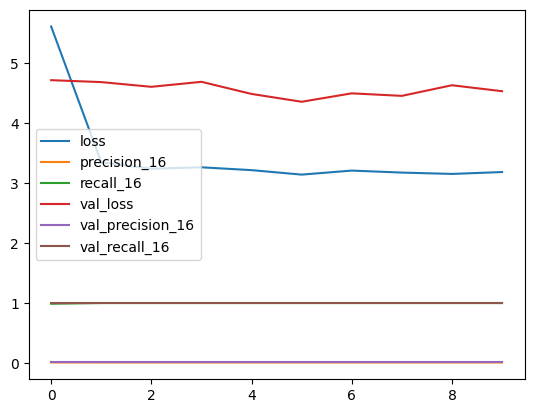

In [94]:
vis_data = pd.DataFrame(history.history)
vis_data.plot()

In [42]:
y_pred = model.predict(X_test)

36/36 [==============================] - 0s 2ms/step


# ROC and AUC
To see how well our model is performing, the ROC and AUC metrics are good.

ROC will tell us the tradeoff between how many fraudulent transactions are correctly identified (true positive rate) and how many legitimate transactions are identified incorrectly as fruadulent (false positive rate), at varying thresholds.




In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

In [44]:
thresholds

array([1.0119883 , 0.0119883 , 0.0102906 , 0.01029011, 0.01020668,
       0.01020383, 0.010001  , 0.01000072, 0.00991722, 0.00991715,
       0.00991443, 0.00991343, 0.00980653, 0.00980575, 0.00968199,
       0.0096812 , 0.0096783 , 0.00967754, 0.00964941, 0.00964826,
       0.00963098, 0.0096306 , 0.00940781, 0.0094077 , 0.00936329,
       0.00936295, 0.00935443, 0.00935436, 0.00935367, 0.00935346,
       0.00930253], dtype=float32)

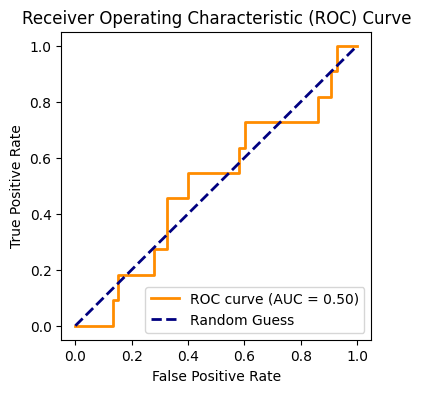

In [45]:
# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [46]:
# Calculate the Area Under the Curve (AUC)
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.5007292173067573

In [47]:
final_df = pd.DataFrame()
final_df["Y_original"] = y_test
#threshold = 0.5
final_df["Y_predicted"] = y_pred

In [48]:
final_df[final_df['Y_original']==1]

,Y_original,Y_predicted
10810,1,0.010290
11170,1,0.009648
11080,1,0.009917
11219,1,0.009631
11121,1,0.009806
11287,1,0.009363
11260,1,0.009408
10997,1,0.010001
11071,1,0.009913
11045,1,0.010204


# Confusion Matrix
Although the ROC curve gives us a visual representation of how well the model is performing in terms of predicting postitive(malicious) transaction samples, the cost of high number of false positives (legit transactions being classified as fraudulent) or false negatives (missing fruadulent transactions) rate is high.

For example, if the model performs best at a low threshold, it means in a real life scenario it is more likely that legitimate transactions are flagged as fradulent. This may be a tradeoff that is not acceptable

Therefore it is important to the model's performance at a *given* threshold, one that is appropriate in this setting.

Other metrics that are helpful in our case are the precision and recall.

The precision allows us to identify how accurate the model's predictions are, which is an important factor in fraud detection because as mentioned, the false negative and false positive rates can have severe consquences.


 while recall allows us to see whether the model can correctly predict all of the fraudulent transactions in our test sample.





In [49]:
best_tpr_index = np.argmax(tpr- fpr)
best_threshold = thresholds[best_tpr_index]
best_threshold

0.009805752

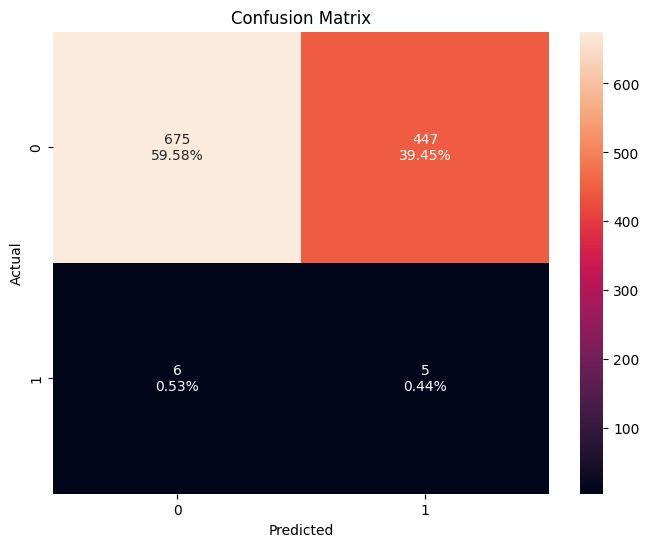

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      1122
           1       0.01      0.45      0.02        11

    accuracy                           0.60      1133
   macro avg       0.50      0.53      0.39      1133
weighted avg       0.98      0.60      0.74      1133



In [50]:
predictions = (y_pred > best_threshold).astype(int)
y_true = y_test
cm = confusion_matrix(y_true, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))

group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='s')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report for additional metrics
print("Classification Report:")
print(classification_report(y_true, predictions))
